In [42]:
import networkx as nx
import math
import csv
import random as rand
import sys
import heapq
import matplotlib.pyplot as plt

In [43]:
mod = []

In [44]:
def buildGraph(G, file_, delimiter_):
    
    reader = csv.reader(open(file_), delimiter=delimiter_)
    for line in reader:
        
        #line format: u,v
        G.add_edge(int(line[0]),int(line[1]),weight=1.0)

In [45]:
def build_level(G, root):
        
        levels = {}
        predecessors = {}
        successors = {}

        cur_level_nodes = [root]    
        nodes = []  
        level_idx = 0       
        while cur_level_nodes:  
            nodes.extend(cur_level_nodes)   
            levels.setdefault(level_idx, cur_level_nodes)   
            next_level_nodes = []   

            # find node in next level
            for node in cur_level_nodes:
                nei_nodes = G.neighbors(node)   
                
                # find neighbor nodes in the next level
                for nei_node in nei_nodes:
                    if nei_node not in nodes:   
                        predecessors.setdefault(nei_node, [])   
                        predecessors[nei_node].append(node) 
                        successors.setdefault(node, [])     
                        successors[node].append(nei_node)

                        if nei_node not in next_level_nodes:    
                            next_level_nodes.append(nei_node)
            cur_level_nodes = next_level_nodes
            level_idx += 1
        return levels, predecessors, successors

In [46]:
def calculate_credits(G, levels, predecessors, successors, nodes_nsp):
        
        nodes_credit = {}
        edges_credit = {}

        # loop, from bottom to top, not including the zero level
        for lvl_idx in range(len(levels)-1, 0, -1):
            lvl_nodes = levels[lvl_idx]     

            # calculate for each node in current level
            for lvl_node in lvl_nodes:
                nodes_credit.setdefault(lvl_node, 1.)   
                if lvl_node in successors:        
                    
                    for successor in successors[lvl_node]:
                        nodes_credit[lvl_node] += edges_credit[(successor, lvl_node)]

                node_predecessors = predecessors[lvl_node]  
                total_nodes_nsp = .0    
                
                # sum up for total_nodes_nsp
                for predecessor in node_predecessors:
                    total_nodes_nsp += nodes_nsp[predecessor]

                # again, calculate for the weight of each predecessor, and assign credit for the responding edge
                for predecessor in node_predecessors:
                    predecessor_weight = nodes_nsp[predecessor]/total_nodes_nsp     # calculate weight of predecssor
                    edges_credit.setdefault((lvl_node, predecessor), nodes_credit[lvl_node]*predecessor_weight)         # bottom-up edge
        return nodes_credit, edges_credit

In [47]:
def get_betweeness_centrality(G):
        graph_nodes = G.nodes()
        edge_contributions = {}
        components = list(nx.connected_components(G))   # connected components for current graph

        # calculate for each node
        for node in graph_nodes:
            
            component = None    # the community current node belongs to
            for com in components: 
                if node in list(com):
                    component = list(com)
            nodes_nsp = {}  # number of shorest paths
            node_levels, predecessors, successors = build_level(G, node)   # build levels for calculation

            # calculate shortest paths for each node (including current node)
            for other_node in component:
                shortest_paths = nx.all_shortest_paths(G, source=node,target=other_node)
                nodes_nsp[other_node] = len(list(shortest_paths))

            # calculate credits for nodes and edges (Only use "edges_credit" actually)
            nodes_credit, edges_credit = calculate_credits(G, node_levels, predecessors, successors, nodes_nsp)

            # sort tuple (key value of edges_credit), and sum up for edge_contributions
            for (k, v) in edges_credit.items():
                k = sorted(k, reverse=False)
                edge_contributions_key = (k[0], k[1])
                edge_contributions.setdefault(edge_contributions_key, 0)
                edge_contributions[edge_contributions_key] += v
           
        # divide by 2 to get true betweenness
        for (k, v) in edge_contributions.items():
            edge_contributions[k] = v/2
        return edge_contributions
    

In [54]:
def bestSplitGirvanNewmanStep(G):
   
    init_ncomp = nx.number_connected_components(G)    #no of components
    ncomp = init_ncomp
    while ncomp <= init_ncomp:
        #bw = nx.edge_betweenness_centrality(G, weight='weight')    #edge betweenness for G
        bw = get_betweeness_centrality(G)
        
        #find the edge with max centrality
        max_ = heapq.nlargest(5,bw.values())
        #find the edge with the highest centrality and remove all of them if there is more than one!
        for k, v in bw.items():
            if float(v) in max_:
                print("removed:",k[0]," k[1]:",k[1])
                G.remove_edge(k[0],k[1])    #remove the central edge
        ncomp = nx.number_connected_components(G)    #recalculate the no of components

In [55]:
#compute the modularity of current split
def _GirvanNewmanGetModularity(G, deg_, m_):
    New_A = nx.adj_matrix(G)
    New_deg = {}
    New_deg = getDegrees(New_A, G.nodes())
    #Let's compute the Q
    comps = nx.connected_components(G)    #list of components    
    print('No of communities in decomposed G: ',nx.number_connected_components(G))
    Mod = 0    #Modularity of a given partitionning
    for c in comps:
        E = 0    #no of edges within a community
        R = 0    #no of random edges
        for u in c:
            E += New_deg[u]
            R += deg_[u]        #count the probability of a random edge
        Mod += ( float(E) - float(R*R)/float(2*m_) )
    Mod = Mod/float(2*m_)
    
    print("Modularity: %f" % Mod)
    return Mod

In [59]:
def getDegrees(A, nodes):
    deg_dict = {}
    nodes = list(nodes)
    n = len(nodes)  
    B = A.sum(axis = 1)
    for i in range(n):
        
        deg_dict[nodes[i]] = B[i, 0]
    
    return deg_dict

In [60]:
def runGirvanNewman(G, Orig_deg, m_):
    #let's find the best split of the graph
    BestQ = 0.0
    Q = 0.0
    itera = 0
    modularity = []
    while True:    
        print("iteration:",itera)
        itera+=1
        bestSplitGirvanNewmanStep(G)
        print("done splitting and updating graph")
        Q = _GirvanNewmanGetModularity(G, Orig_deg, m_)
        modularity.append(Q)
        mod.append(Q)
        print("done computing modularity")
        print("Modularity of decomposed G: %f" % Q)
        if Q > BestQ:
            BestQ = Q
            Bestcomps = nx.connected_components(G)    #Best Split
            print("Components:", Bestcomps)
        if G.number_of_edges() == 0:
            break
    if BestQ > 0.0:
        print("Max modularity (Q): %f" % BestQ)
        print("Graph communities:", Bestcomps)
    else:
        print("Max modularity (Q): %f" % BestQ)
    return modularity

In [61]:

G = nx.Graph()  #let's create the graph first
buildGraph(G, "Downloads/edges_sampled_map_2K.csv", ',')
n = G.number_of_nodes()    #|V|
A = nx.adj_matrix(G)    #adjacenct matrix

m_ = 0.0    #the weighted version for number of edges
for i in range(0,n):
    for j in range(0,n):
        m_ += A[i,j]
m_ = m_/2.0
Orig_deg = {}
Orig_deg = getDegrees(A, G.nodes())
modularity=runGirvanNewman(G, Orig_deg, m_)

adjacency:   (0, 1)	1.0
  (0, 2)	1.0
  (0, 3)	1.0
  (0, 4)	1.0
  (0, 5)	1.0
  (0, 6)	1.0
  (0, 7)	1.0
  (0, 8)	1.0
  (0, 9)	1.0
  (0, 21)	1.0
  (0, 28)	1.0
  (0, 42)	1.0
  (0, 46)	1.0
  (0, 61)	1.0
  (0, 72)	1.0
  (0, 75)	1.0
  (0, 77)	1.0
  (0, 109)	1.0
  (0, 112)	1.0
  (0, 133)	1.0
  (0, 151)	1.0
  (0, 300)	1.0
  (1, 0)	1.0
  (1, 15)	1.0
  (1, 19)	1.0
  :	:
  (311, 172)	1.0
  (311, 173)	1.0
  (311, 181)	1.0
  (311, 183)	1.0
  (311, 185)	1.0
  (311, 186)	1.0
  (311, 217)	1.0
  (311, 220)	1.0
  (311, 227)	1.0
  (311, 238)	1.0
  (311, 239)	1.0
  (311, 241)	1.0
  (311, 242)	1.0
  (311, 246)	1.0
  (311, 247)	1.0
  (311, 248)	1.0
  (311, 277)	1.0
  (311, 306)	1.0
  (311, 310)	1.0
  (312, 306)	1.0
  (313, 314)	1.0
  (314, 313)	1.0
  (315, 316)	1.0
  (316, 315)	1.0
  (317, 93)	1.0
B: [[22.]
 [23.]
 [31.]
 [18.]
 [ 3.]
 [ 7.]
 [25.]
 [ 8.]
 [42.]
 [ 5.]
 [12.]
 [19.]
 [ 6.]
 [58.]
 [20.]
 [48.]
 [23.]
 [16.]
 [ 2.]
 [46.]
 [25.]
 [48.]
 [64.]
 [ 1.]
 [32.]
 [11.]
 [ 8.]
 [19.]
 [64.]
 [12.]
 

KeyboardInterrupt: 

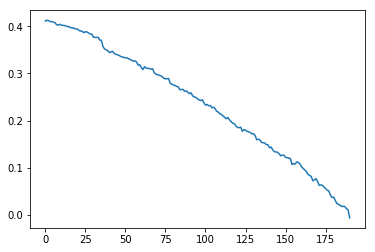

In [53]:
plt.plot(mod)